# V.8

- efficientnet_b5 사용
- 이미지 상단 제목 데이터 추가

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from augraphy import *

from sklearn.metrics import accuracy_score, f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

In [2]:
wandb.login(key='2a6ed9b82b10f4c201952cf2948e01f8a0b197ab')
run = wandb.init(project='CV_contest_V8', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

# CustomDataset

In [6]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms, pipeline):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms
        self.pipeline = pipeline

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.pipeline(img)
        img = self.transforms(img)
    
        return img, target

In [7]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [8]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(550,550), scale=(0.5, 1.0)),
    T.Resize((500, 500))
])

augmentations = [
    NoiseTexturize(sigma_range=(6, 10),
                  turbulence_range=(5, 10),
                  texture_width_range=(50, 500),
                  texture_height_range=(50, 500)),
    BrightnessTexturize(texturize_range=(0.9, 0.99), deviation=0.2),
    Folding(fold_count=2,
            fold_noise=0.0,
            fold_angle_range = (-180,180),
            gradient_width=(0.01, 0.05),
            gradient_height=(0.01, 0.05),
            backdrop_color = (0,0,0)),
    BadPhotoCopy(
        noise_type=-1,
        noise_side="random",
        noise_iteration=(1, 2),
        noise_size=(1, 3),
        noise_value=(128, 196),
        noise_sparsity=(0.3, 0.6),
        noise_concentration=(0.1, 0.6),
        blur_noise=random.choice([True, False]),
        blur_noise_kernel=random.choice([(3, 3), (5, 5), (7, 7)]),
        wave_pattern=random.choice([True, False]),
        edge_effect=random.choice([True, False]),
        p=0.33,
    ),    
]

pipeline = AugraphyPipeline(augmentations)

train_dataset = customdataset('/data/ephemeral/home/data/modified_train.csv', '/data/ephemeral/home/data/train', transforms=aug_transforms, pipeline=pipeline)

In [9]:
len(train_dataset)

1570

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


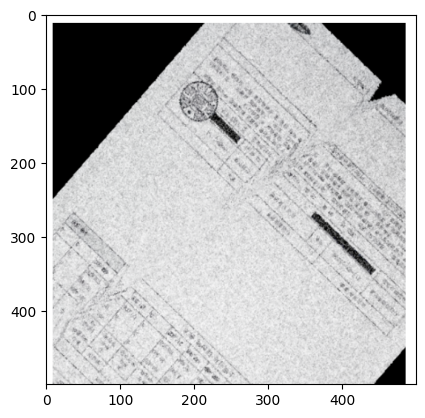

In [10]:
plt.imshow(train_dataset[1][0].permute(1, 2, 0))

# valid dataset

## 민준형 최고 점수 결과 사용

In [11]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((500, 500))
])

pipeline = AugraphyPipeline()

valid_dataset = customdataset('/data/ephemeral/home/preds/minjun_best_score_3.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms, pipeline=pipeline) # valid dataset

In [12]:
len(valid_dataset)

3140

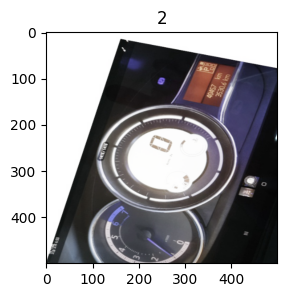

In [13]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.title(valid_dataset[0][1])
plt.show()

In [14]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

### 학습전 모델 이름 바꿔주기!!

In [15]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v8_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 50:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v8_last.pt")
            print('Early Stopping')
            break

    return model

In [16]:
model = timm.create_model(
    'efficientnet_b5',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 500)

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 2.3743, Train Accuracy: 0.2516 Valid Loss: 2.5924, Valid Accuracy: 0.2465


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [2/500], Train Loss: 1.7274, Train Accuracy: 0.4344 Valid Loss: 3.1294, Valid Accuracy: 0.2981


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [3/500], Train Loss: 1.3937, Train Accuracy: 0.5299 Valid Loss: 3.0453, Valid Accuracy: 0.3599


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [4/500], Train Loss: 1.3146, Train Accuracy: 0.5529 Valid Loss: 2.4173, Valid Accuracy: 0.3889


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [5/500], Train Loss: 1.1122, Train Accuracy: 0.6178 Valid Loss: 1.4793, Valid Accuracy: 0.5169


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [6/500], Train Loss: 1.0384, Train Accuracy: 0.6611 Valid Loss: 1.2996, Valid Accuracy: 0.5710


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [7/500], Train Loss: 0.9953, Train Accuracy: 0.6631 Valid Loss: 2.0059, Valid Accuracy: 0.4439


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [8/500], Train Loss: 0.9576, Train Accuracy: 0.6764 Valid Loss: 1.9483, Valid Accuracy: 0.5016


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [9/500], Train Loss: 0.8918, Train Accuracy: 0.6994 Valid Loss: 2.4032, Valid Accuracy: 0.4318


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [10/500], Train Loss: 0.8050, Train Accuracy: 0.7210 Valid Loss: 1.8620, Valid Accuracy: 0.5019


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [11/500], Train Loss: 0.7993, Train Accuracy: 0.7236 Valid Loss: 1.1554, Valid Accuracy: 0.6503


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [12/500], Train Loss: 0.7136, Train Accuracy: 0.7618 Valid Loss: 1.1927, Valid Accuracy: 0.6338


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [13/500], Train Loss: 0.6505, Train Accuracy: 0.7815 Valid Loss: 1.5204, Valid Accuracy: 0.5898


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [14/500], Train Loss: 0.7168, Train Accuracy: 0.7522 Valid Loss: 0.8560, Valid Accuracy: 0.7280


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [15/500], Train Loss: 0.6324, Train Accuracy: 0.7764 Valid Loss: 1.6382, Valid Accuracy: 0.5382


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [16/500], Train Loss: 0.7127, Train Accuracy: 0.7401 Valid Loss: 1.2776, Valid Accuracy: 0.6191


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [17/500], Train Loss: 0.6473, Train Accuracy: 0.7752 Valid Loss: 2.2708, Valid Accuracy: 0.4506


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [18/500], Train Loss: 0.6463, Train Accuracy: 0.7758 Valid Loss: 1.0932, Valid Accuracy: 0.6672


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [19/500], Train Loss: 0.6020, Train Accuracy: 0.7924 Valid Loss: 1.2843, Valid Accuracy: 0.6764


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [20/500], Train Loss: 0.5721, Train Accuracy: 0.7949 Valid Loss: 2.1013, Valid Accuracy: 0.5656


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [21/500], Train Loss: 0.6163, Train Accuracy: 0.7834 Valid Loss: 1.3223, Valid Accuracy: 0.6395


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [22/500], Train Loss: 0.5612, Train Accuracy: 0.8038 Valid Loss: 1.1591, Valid Accuracy: 0.6892


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [23/500], Train Loss: 0.6311, Train Accuracy: 0.7841 Valid Loss: 5.2033, Valid Accuracy: 0.1436


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [24/500], Train Loss: 0.5452, Train Accuracy: 0.8121 Valid Loss: 1.1676, Valid Accuracy: 0.6822


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [25/500], Train Loss: 0.4951, Train Accuracy: 0.8236 Valid Loss: 0.8825, Valid Accuracy: 0.7331


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [26/500], Train Loss: 0.4815, Train Accuracy: 0.8344 Valid Loss: 2.0333, Valid Accuracy: 0.4959


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [27/500], Train Loss: 0.4903, Train Accuracy: 0.8306 Valid Loss: 1.0180, Valid Accuracy: 0.7194


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [28/500], Train Loss: 0.4643, Train Accuracy: 0.8312 Valid Loss: 1.6667, Valid Accuracy: 0.5955


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [29/500], Train Loss: 0.4796, Train Accuracy: 0.8395 Valid Loss: 1.9435, Valid Accuracy: 0.5414


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [30/500], Train Loss: 0.4417, Train Accuracy: 0.8382 Valid Loss: 0.9042, Valid Accuracy: 0.7373


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [31/500], Train Loss: 0.4761, Train Accuracy: 0.8306 Valid Loss: 1.2300, Valid Accuracy: 0.6818


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [32/500], Train Loss: 0.4507, Train Accuracy: 0.8414 Valid Loss: 1.9163, Valid Accuracy: 0.5838


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [33/500], Train Loss: 0.4358, Train Accuracy: 0.8459 Valid Loss: 0.8716, Valid Accuracy: 0.7417


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [34/500], Train Loss: 0.4241, Train Accuracy: 0.8414 Valid Loss: 1.4799, Valid Accuracy: 0.6592


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [35/500], Train Loss: 0.4672, Train Accuracy: 0.8433 Valid Loss: 1.2789, Valid Accuracy: 0.6803


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [36/500], Train Loss: 0.4448, Train Accuracy: 0.8433 Valid Loss: 1.0694, Valid Accuracy: 0.7287


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [37/500], Train Loss: 0.4239, Train Accuracy: 0.8535 Valid Loss: 1.2798, Valid Accuracy: 0.6710


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [38/500], Train Loss: 0.4069, Train Accuracy: 0.8541 Valid Loss: 1.7859, Valid Accuracy: 0.5946


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [39/500], Train Loss: 0.4131, Train Accuracy: 0.8484 Valid Loss: 1.1086, Valid Accuracy: 0.7172


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [40/500], Train Loss: 0.4038, Train Accuracy: 0.8503 Valid Loss: 1.2087, Valid Accuracy: 0.6949


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [41/500], Train Loss: 0.3830, Train Accuracy: 0.8618 Valid Loss: 1.8962, Valid Accuracy: 0.5732


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [42/500], Train Loss: 0.4088, Train Accuracy: 0.8497 Valid Loss: 0.8937, Valid Accuracy: 0.7643


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [43/500], Train Loss: 0.3828, Train Accuracy: 0.8650 Valid Loss: 0.9532, Valid Accuracy: 0.7417


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [44/500], Train Loss: 0.3601, Train Accuracy: 0.8713 Valid Loss: 1.1261, Valid Accuracy: 0.7134


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [45/500], Train Loss: 0.3452, Train Accuracy: 0.8739 Valid Loss: 1.0369, Valid Accuracy: 0.7258


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [46/500], Train Loss: 0.3674, Train Accuracy: 0.8624 Valid Loss: 1.2434, Valid Accuracy: 0.6822


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [47/500], Train Loss: 0.3392, Train Accuracy: 0.8809 Valid Loss: 1.1357, Valid Accuracy: 0.7153


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [48/500], Train Loss: 0.3385, Train Accuracy: 0.8771 Valid Loss: 1.3004, Valid Accuracy: 0.6908


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [49/500], Train Loss: 0.3343, Train Accuracy: 0.8720 Valid Loss: 1.8051, Valid Accuracy: 0.6035


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [50/500], Train Loss: 0.3266, Train Accuracy: 0.8803 Valid Loss: 3.1727, Valid Accuracy: 0.4127


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [51/500], Train Loss: 0.4006, Train Accuracy: 0.8573 Valid Loss: 1.1089, Valid Accuracy: 0.6990


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [52/500], Train Loss: 0.3343, Train Accuracy: 0.8796 Valid Loss: 1.3288, Valid Accuracy: 0.7166


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [53/500], Train Loss: 0.3326, Train Accuracy: 0.8828 Valid Loss: 0.9206, Valid Accuracy: 0.7487


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [54/500], Train Loss: 0.3053, Train Accuracy: 0.8892 Valid Loss: 0.9147, Valid Accuracy: 0.7459


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [55/500], Train Loss: 0.2871, Train Accuracy: 0.9019 Valid Loss: 1.9049, Valid Accuracy: 0.6191


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [56/500], Train Loss: 0.3054, Train Accuracy: 0.8783 Valid Loss: 1.3858, Valid Accuracy: 0.6704


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [57/500], Train Loss: 0.2870, Train Accuracy: 0.8981 Valid Loss: 0.8449, Valid Accuracy: 0.7831


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [58/500], Train Loss: 0.2854, Train Accuracy: 0.8987 Valid Loss: 1.5077, Valid Accuracy: 0.7105


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [59/500], Train Loss: 0.3063, Train Accuracy: 0.8892 Valid Loss: 0.9134, Valid Accuracy: 0.7701


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [60/500], Train Loss: 0.3185, Train Accuracy: 0.8828 Valid Loss: 0.9663, Valid Accuracy: 0.7408


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [61/500], Train Loss: 0.2586, Train Accuracy: 0.9051 Valid Loss: 1.0565, Valid Accuracy: 0.7640


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [62/500], Train Loss: 0.2572, Train Accuracy: 0.9102 Valid Loss: 1.0902, Valid Accuracy: 0.7347


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [63/500], Train Loss: 0.2841, Train Accuracy: 0.8955 Valid Loss: 4.4173, Valid Accuracy: 0.2583


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [64/500], Train Loss: 0.2411, Train Accuracy: 0.9045 Valid Loss: 1.8351, Valid Accuracy: 0.6245


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [65/500], Train Loss: 0.2898, Train Accuracy: 0.9019 Valid Loss: 1.3688, Valid Accuracy: 0.6997


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [66/500], Train Loss: 0.2976, Train Accuracy: 0.8879 Valid Loss: 1.2606, Valid Accuracy: 0.7248


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [67/500], Train Loss: 0.2496, Train Accuracy: 0.9089 Valid Loss: 4.2026, Valid Accuracy: 0.3503


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [68/500], Train Loss: 0.2532, Train Accuracy: 0.9159 Valid Loss: 1.0332, Valid Accuracy: 0.7465


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [69/500], Train Loss: 0.2242, Train Accuracy: 0.9217 Valid Loss: 1.4886, Valid Accuracy: 0.7019


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [70/500], Train Loss: 0.2809, Train Accuracy: 0.8981 Valid Loss: 0.8807, Valid Accuracy: 0.7637


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [71/500], Train Loss: 0.2911, Train Accuracy: 0.8987 Valid Loss: 0.9962, Valid Accuracy: 0.7637


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [72/500], Train Loss: 0.2579, Train Accuracy: 0.9108 Valid Loss: 1.5602, Valid Accuracy: 0.6296


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [73/500], Train Loss: 0.2240, Train Accuracy: 0.9217 Valid Loss: 3.2847, Valid Accuracy: 0.4436


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [74/500], Train Loss: 0.2286, Train Accuracy: 0.9185 Valid Loss: 1.1032, Valid Accuracy: 0.7548


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [75/500], Train Loss: 0.2251, Train Accuracy: 0.9223 Valid Loss: 1.3386, Valid Accuracy: 0.7194


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [76/500], Train Loss: 0.2082, Train Accuracy: 0.9197 Valid Loss: 1.2618, Valid Accuracy: 0.7490


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [77/500], Train Loss: 0.2318, Train Accuracy: 0.9134 Valid Loss: 1.0457, Valid Accuracy: 0.7519


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [78/500], Train Loss: 0.2833, Train Accuracy: 0.9045 Valid Loss: 1.1021, Valid Accuracy: 0.7701


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [79/500], Train Loss: 0.2613, Train Accuracy: 0.9038 Valid Loss: 1.0474, Valid Accuracy: 0.7627


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [80/500], Train Loss: 0.1957, Train Accuracy: 0.9331 Valid Loss: 1.0172, Valid Accuracy: 0.7586


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [81/500], Train Loss: 0.2461, Train Accuracy: 0.9127 Valid Loss: 0.9444, Valid Accuracy: 0.7809


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [82/500], Train Loss: 0.2185, Train Accuracy: 0.9197 Valid Loss: 1.1714, Valid Accuracy: 0.7599


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [83/500], Train Loss: 0.1892, Train Accuracy: 0.9299 Valid Loss: 4.9529, Valid Accuracy: 0.2736


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [84/500], Train Loss: 0.2627, Train Accuracy: 0.9134 Valid Loss: 0.8743, Valid Accuracy: 0.7857


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [85/500], Train Loss: 0.2020, Train Accuracy: 0.9261 Valid Loss: 1.2941, Valid Accuracy: 0.7248


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [86/500], Train Loss: 0.1622, Train Accuracy: 0.9446 Valid Loss: 1.0239, Valid Accuracy: 0.7608


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [87/500], Train Loss: 0.2631, Train Accuracy: 0.9134 Valid Loss: 1.2183, Valid Accuracy: 0.7478


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [88/500], Train Loss: 0.2331, Train Accuracy: 0.9134 Valid Loss: 1.2787, Valid Accuracy: 0.7347


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [89/500], Train Loss: 0.2000, Train Accuracy: 0.9268 Valid Loss: 1.5834, Valid Accuracy: 0.7194


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [90/500], Train Loss: 0.1821, Train Accuracy: 0.9363 Valid Loss: 1.3990, Valid Accuracy: 0.7277


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [91/500], Train Loss: 0.1757, Train Accuracy: 0.9344 Valid Loss: 1.7490, Valid Accuracy: 0.6764


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [92/500], Train Loss: 0.1968, Train Accuracy: 0.9306 Valid Loss: 1.5308, Valid Accuracy: 0.6838


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [93/500], Train Loss: 0.1931, Train Accuracy: 0.9293 Valid Loss: 0.9119, Valid Accuracy: 0.7669


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [94/500], Train Loss: 0.1783, Train Accuracy: 0.9325 Valid Loss: 0.9017, Valid Accuracy: 0.7662


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [95/500], Train Loss: 0.1717, Train Accuracy: 0.9414 Valid Loss: 1.6959, Valid Accuracy: 0.6981


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [96/500], Train Loss: 0.1925, Train Accuracy: 0.9382 Valid Loss: 1.0605, Valid Accuracy: 0.7535


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [97/500], Train Loss: 0.1849, Train Accuracy: 0.9350 Valid Loss: 1.3772, Valid Accuracy: 0.7140


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [98/500], Train Loss: 0.1718, Train Accuracy: 0.9389 Valid Loss: 1.1092, Valid Accuracy: 0.7561


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [99/500], Train Loss: 0.1562, Train Accuracy: 0.9446 Valid Loss: 1.3263, Valid Accuracy: 0.7309


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [100/500], Train Loss: 0.1601, Train Accuracy: 0.9414 Valid Loss: 1.4041, Valid Accuracy: 0.7268


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [101/500], Train Loss: 0.1812, Train Accuracy: 0.9420 Valid Loss: 1.1061, Valid Accuracy: 0.7876


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [102/500], Train Loss: 0.2096, Train Accuracy: 0.9318 Valid Loss: 1.3062, Valid Accuracy: 0.7411


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [103/500], Train Loss: 0.1761, Train Accuracy: 0.9331 Valid Loss: 1.1593, Valid Accuracy: 0.7793


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [104/500], Train Loss: 0.1544, Train Accuracy: 0.9478 Valid Loss: 1.6346, Valid Accuracy: 0.7048


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [105/500], Train Loss: 0.1973, Train Accuracy: 0.9395 Valid Loss: 1.6269, Valid Accuracy: 0.7471


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [106/500], Train Loss: 0.1702, Train Accuracy: 0.9401 Valid Loss: 1.1703, Valid Accuracy: 0.7596


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [107/500], Train Loss: 0.1601, Train Accuracy: 0.9465 Valid Loss: 1.1151, Valid Accuracy: 0.7882
Early Stopping


# Submission

In [19]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [20]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((500, 500))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [21]:
batch_size = 8

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [22]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/393 [00:00<?, ?it/s]

In [23]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(10, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(2, device='cuda:0'),
 

In [24]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [25]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [26]:
sub_df.to_csv('/data/ephemeral/home/preds/v8_last_preds.csv', index=False)

In [31]:
cnt_list = [0 for _ in range(17)]

for i in range(17):
    cnt_list.append(sub_df[sub_df['target']==i].shape[0])

print(cnt_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 77, 294, 232, 125, 182, 118, 267, 232, 193, 208, 169, 230, 151, 150, 176, 155]


: 